<a href="https://colab.research.google.com/github/ccsed/ProgettoLabAI/blob/main/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Collego colab a google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import os

def conta_file(directory):
    try:

        elementi = os.listdir(directory)

        file = [f for f in elementi if os.path.isfile(os.path.join(directory, f))]

        numero_file = len(file)
        return numero_file
    except Exception as e:
        print(f"Errore: {e}")
        return 0

directory_path = '/content/Labels'
print(f"Numero di file nella directory: {conta_file(directory_path)}")


Numero di file nella directory: 3401


Importo le librerie necessarie

In [14]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 66.3 MB/s eta 0:00:00


In [40]:
import os
import numpy as np
import rasterio
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import albumentations as A
from PIL import Image
import matplotlib.pyplot as plt
import random
import skimage.io as io
from rasterio.plot import show
import torch.nn as nn
import torchvision.transforms.functional as TF
from albumentations.pytorch import ToTensorV2
import torch.optim as optim
from tqdm import tqdm
import torchvision
from osgeo import gdal
import cv2
import tifffile as tiff
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

Definisco alcune directory

In [16]:
drive_dir = '/content/drive/MyDrive'
image_dir = '/content/drive/MyDrive/Data/SN6_buildings_AOI_11_Rotterdam_train/train/AOI_11_Rotterdam/SAR-Intensity'
train_path = '/content/drive/MyDrive/train.txt'
val_path = '/content/drive/MyDrive/val.txt'
test_path = '/content/drive/MyDrive/test.txt'

Media e std calcolate in Funzioni.ipynb

In [34]:
mean = [22.79312241, 24.30391245, 19.29892107, 17.69439361]
std = [16.42519281, 17.42876255, 14.27711349, 13.24714869]
# mean = [0.0, 0.0, 0.0, 0.0]
# std = [1.0, 1.0, 1.0, 1.0]

Definiamo la classe SARDataset

In [19]:
class SARDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]


        with rasterio.open(image_path) as src:
            image = src.read().transpose((1, 2, 0))
            # print(image.shape)
            image = image.astype(np.float32)

        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.float32)
            # print(mask.shape)
            mask[mask == 255.0] = 1.0


        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask


Carico i percorsi delle immagini per il training, il validation e il test set

In [20]:
with open(train_path, 'r') as f:
    train_data = [line.split() for line in f.read().splitlines()]

train_image_paths = [line[0] for line in train_data]
train_label_paths = ['/' + line[1] for line in train_data]

with open(val_path, 'r') as f:
    val_data = [line.split() for line in f.read().splitlines()]

val_image_paths = [line[0] for line in val_data]
val_label_paths = ['/' + line[1] for line in val_data]

with open(test_path, 'r') as f:
    test_data = [line.split() for line in f.read().splitlines()]

test_image_paths = [line[0] for line in test_data]
test_label_paths = ['/' + line[1] for line in test_data]

Creo il modello UNET

Classe DoubleConv

In [21]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)



Classe UNET

In [22]:
class UNET(nn.Module):
  def __init__(
      self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
  ):
    super(UNET, self).__init__()
    self.ups = nn.ModuleList()
    self.downs = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature))
      in_channels = feature

    for feature in reversed(features):
      self.ups.append(
          nn.ConvTranspose2d(
              feature*2, feature, kernel_size=2, stride=2,
          )
      )
      self.ups.append(DoubleConv(feature*2, feature))

    self.bottleneck = DoubleConv(features[-1], features[-1]*2)
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x)
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for idx in range(0, len(self.ups), 2):
      x = self.ups[idx](x)
      skip_connection = skip_connections[idx//2]

      if x.shape != skip_connection.shape:
        x = TF.resize(x, size=skip_connection.shape[2:])

      concat_skip = torch.cat((skip_connection, x), dim=1)
      x = self.ups[idx+1](concat_skip)

    return self.final_conv(x)

Seed

In [23]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

Funzione per il training

In [24]:
def train_fn(loader, model, optimizer, loss_fn, scaler, txtfile):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=device)
        targets = targets.float().to(device=device)

        with torch.cuda.amp.autocast():
            predictions = model(data).squeeze(1)
            loss = loss_fn(predictions, targets)


        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loop.set_postfix(loss=loss.item())
        loss1 = loss.item()

    with open(txtfile, "a") as f:
        f.write(f"Train Loss: {loss1:.4f}\n")


Utils

In [25]:
def save_checkpoint(state, filename="/content/drive/MyDrive/model1/checkpoint.pth.tar"):
  print("=> Saving checkpoint")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

Evaluation function

In [26]:
def eval_fn(loader, model, loss_fn, txtfile, device="cuda"):
    model.eval()
    num_correct = 0
    num_pixels = 0
    total_dice_score = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_loss = 0

    with torch.no_grad():
        for num_it, (x, y) in enumerate(loader, start=1):
            x = x.to(device)
            y = y.to(device)
            out = model(x).squeeze(1)
            loss = loss_fn(out, y)
            total_loss += loss.item()
            preds = torch.sigmoid(out)
            preds = (preds > 0.5).float()

            num_correct += (preds == y).sum().item()
            num_pixels += torch.numel(preds)

            dice_score = (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
            total_dice_score += dice_score.item()

            y_np = y.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            total_precision += precision_score(y_np, preds_np, zero_division=1)
            total_recall += recall_score(y_np, preds_np, zero_division=1)
            total_f1 += f1_score(y_np, preds_np, zero_division=1)

    avg_loss = total_loss / len(loader)
    avg_dice_score = total_dice_score / len(loader)
    avg_precision = total_precision / len(loader)
    avg_recall = total_recall / len(loader)
    avg_f1 = total_f1 / len(loader)
    accuracy = num_correct / num_pixels * 100

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Dice score: {avg_dice_score:.4f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 Score: {avg_f1:.4f}")

    with open(txtfile, "a") as f:
        f.write(f"Validation Loss: {avg_loss:.4f}\n")
        f.write(f"Accuracy: {accuracy:.2f}\n")
        f.write(f"Dice score: {avg_dice_score:.4f}\n")
        f.write(f"Precision: {avg_precision:.4f}\n")
        f.write(f"Recall: {avg_recall:.4f}\n")
        f.write(f"F1 Score: {avg_f1:.4f}\n")
        f.write("\n")

    model.train()
    return avg_loss, accuracy, avg_dice_score, avg_precision, avg_recall, avg_f1

In [27]:
def save_predictions_as_imgs(loader, model, folder, device="cuda"):
    os.makedirs(folder, exist_ok=True)
    model.eval()
    it = 1
    for idx, (x, y) in enumerate(tqdm(loader, desc="Saving predictions")):
        print(it)
        it += 1
        x = x.to(device=device)
        y = y.to(device=device).unsqueeze(1)

        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()

        combined = torch.cat((y, preds), dim=2)
        torchvision.utils.save_image(combined, f"{folder}/comparison_{idx}.png")

    model.train()


Training baseline

In [38]:
set_seed(42)

transform = A.Compose([
    A.CenterCrop(height=896, width=896),
    A.RandomCrop(height=320, width=320),
    # A.HorizontalFlip(p=0.5),
    # A.VerticalFlip(p=0.5),
    # A.Rotate(limit=90, p=0.5),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

train_dataset = SARDataset(train_image_paths, train_label_paths, transform=transform)
val_dataset = SARDataset(val_image_paths, val_label_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
load_model = False
lr = 1e-5
model_dir = "/content/drive/MyDrive/model3"
step_size = 6

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNET(in_channels=4, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler =  ReduceLROnPlateau(optimizer, mode='max', factor=factor, patience=patience, threshold=threshold, verbose=True)
num_epochs = 5
scaler = torch.cuda.amp.GradScaler()

if load_model:
  load_checkpoint(torch.load("/content/drive/MyDrive/model2/checkpoint.pth.tar"), model)



In [37]:
best_f1_score = 0.0

In [39]:


for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    train_fn(train_loader, model, optimizer, criterion, scaler, model_dir + "/output/output.txt")

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint)

    val_loss, val_accuracy, val_dice_score, val_precision, val_recall, val_f1 = eval_fn(val_loader, model, criterion, model_dir + "/output/output.txt", device=device)

    if val_f1 > best_f1_score:
        best_f1_score = val_f1
        save_checkpoint(checkpoint, filename=os.path.join(model_dir, "best_model.pth.tar"))
        print(f"New best F1 score: {best_f1_score:.4f}")

    if (epoch + 1) % 5 == 0:
        save_predictions_as_imgs(val_loader, model, model_dir + "/images/", device=device)

    scheduler.step()


epoch 0


100%|██████████| 149/149 [01:50<00:00,  1.35it/s, loss=0.405]


=> Saving checkpoint
Validation Loss: 0.4541
Accuracy: 91.33
Dice score: 0.0106
Precision: 0.0794
Recall: 0.0057
F1 Score: 0.0106
=> Saving checkpoint
New best F1 score: 0.0106
epoch 1


100%|██████████| 149/149 [01:52<00:00,  1.32it/s, loss=0.373]


=> Saving checkpoint
Validation Loss: 0.4000
Accuracy: 91.70
Dice score: 0.0004
Precision: 0.0858
Recall: 0.0002
F1 Score: 0.0004
epoch 2


100%|██████████| 149/149 [01:47<00:00,  1.39it/s, loss=0.349]


=> Saving checkpoint
Validation Loss: 0.3527
Accuracy: 91.86
Dice score: 0.0020
Precision: 0.2576
Recall: 0.0010
F1 Score: 0.0020
epoch 3


100%|██████████| 149/149 [01:53<00:00,  1.32it/s, loss=0.399]


=> Saving checkpoint
Validation Loss: 0.3385
Accuracy: 92.04
Dice score: 0.2009
Precision: 0.4643
Recall: 0.1314
F1 Score: 0.2009
=> Saving checkpoint
New best F1 score: 0.2009
epoch 4


100%|██████████| 149/149 [01:43<00:00,  1.44it/s, loss=0.345]


=> Saving checkpoint
Validation Loss: 0.3479
Accuracy: 92.08
Dice score: 0.2326
Precision: 0.4077
Recall: 0.1671
F1 Score: 0.2326
=> Saving checkpoint
New best F1 score: 0.2326


Saving predictions:   0%|          | 0/43 [00:00<?, ?it/s]

1


Saving predictions:   2%|▏         | 1/43 [00:01<01:06,  1.59s/it]

2


Saving predictions:   5%|▍         | 2/43 [00:02<00:54,  1.32s/it]

3


Saving predictions:   7%|▋         | 3/43 [00:03<00:40,  1.01s/it]

4


Saving predictions:   9%|▉         | 4/43 [00:04<00:33,  1.16it/s]

5


Saving predictions:  12%|█▏        | 5/43 [00:04<00:29,  1.28it/s]

6


Saving predictions:  14%|█▍        | 6/43 [00:05<00:27,  1.36it/s]

7


Saving predictions:  16%|█▋        | 7/43 [00:05<00:25,  1.42it/s]

8


Saving predictions:  19%|█▊        | 8/43 [00:06<00:23,  1.47it/s]

9


Saving predictions:  21%|██        | 9/43 [00:07<00:22,  1.49it/s]

10


Saving predictions:  23%|██▎       | 10/43 [00:07<00:21,  1.51it/s]

11


Saving predictions:  26%|██▌       | 11/43 [00:08<00:21,  1.52it/s]

12


Saving predictions:  28%|██▊       | 12/43 [00:09<00:20,  1.52it/s]

13


Saving predictions:  30%|███       | 13/43 [00:09<00:19,  1.55it/s]

14


Saving predictions:  33%|███▎      | 14/43 [00:10<00:18,  1.58it/s]

15


Saving predictions:  35%|███▍      | 15/43 [00:11<00:17,  1.56it/s]

16


Saving predictions:  37%|███▋      | 16/43 [00:11<00:17,  1.55it/s]

17


Saving predictions:  40%|███▉      | 17/43 [00:12<00:16,  1.55it/s]

18


Saving predictions:  42%|████▏     | 18/43 [00:12<00:16,  1.55it/s]

19


Saving predictions:  44%|████▍     | 19/43 [00:13<00:15,  1.54it/s]

20


Saving predictions:  47%|████▋     | 20/43 [00:14<00:15,  1.51it/s]

21


Saving predictions:  49%|████▉     | 21/43 [00:14<00:14,  1.53it/s]

22


Saving predictions:  51%|█████     | 22/43 [00:15<00:13,  1.52it/s]

23


Saving predictions:  53%|█████▎    | 23/43 [00:16<00:12,  1.55it/s]

24


Saving predictions:  56%|█████▌    | 24/43 [00:16<00:12,  1.54it/s]

25


Saving predictions:  58%|█████▊    | 25/43 [00:17<00:11,  1.54it/s]

26


Saving predictions:  60%|██████    | 26/43 [00:18<00:11,  1.51it/s]

27


Saving predictions:  63%|██████▎   | 27/43 [00:18<00:10,  1.50it/s]

28


Saving predictions:  65%|██████▌   | 28/43 [00:19<00:09,  1.50it/s]

29


Saving predictions:  67%|██████▋   | 29/43 [00:20<00:09,  1.51it/s]

30


Saving predictions:  70%|██████▉   | 30/43 [00:20<00:08,  1.52it/s]

31


Saving predictions:  72%|███████▏  | 31/43 [00:21<00:07,  1.53it/s]

32


Saving predictions:  74%|███████▍  | 32/43 [00:22<00:07,  1.54it/s]

33


Saving predictions:  77%|███████▋  | 33/43 [00:22<00:06,  1.55it/s]

34


Saving predictions:  79%|███████▉  | 34/43 [00:23<00:05,  1.55it/s]

35


Saving predictions:  81%|████████▏ | 35/43 [00:24<00:05,  1.54it/s]

36


Saving predictions:  84%|████████▎ | 36/43 [00:24<00:04,  1.54it/s]

37


Saving predictions:  86%|████████▌ | 37/43 [00:25<00:03,  1.54it/s]

38


Saving predictions:  88%|████████▊ | 38/43 [00:26<00:03,  1.54it/s]

39


Saving predictions:  91%|█████████ | 39/43 [00:26<00:02,  1.54it/s]

40


Saving predictions:  93%|█████████▎| 40/43 [00:27<00:01,  1.54it/s]

41


Saving predictions:  95%|█████████▌| 41/43 [00:28<00:01,  1.55it/s]

42


Saving predictions:  98%|█████████▊| 42/43 [00:28<00:00,  1.55it/s]

43


Saving predictions: 100%|██████████| 43/43 [00:29<00:00,  1.48it/s]


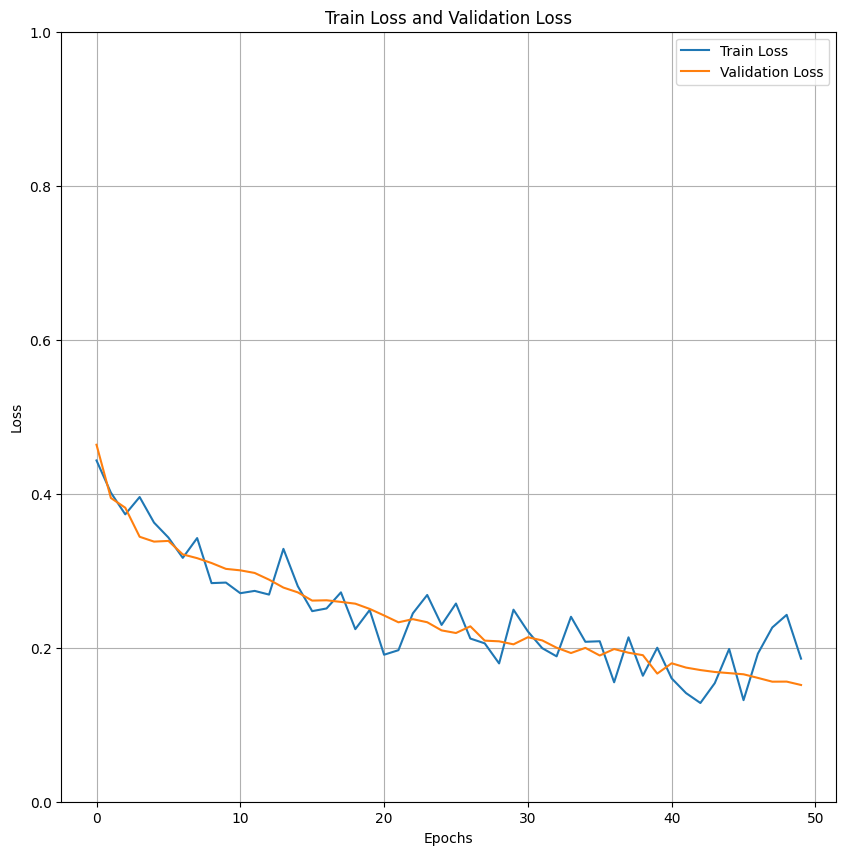

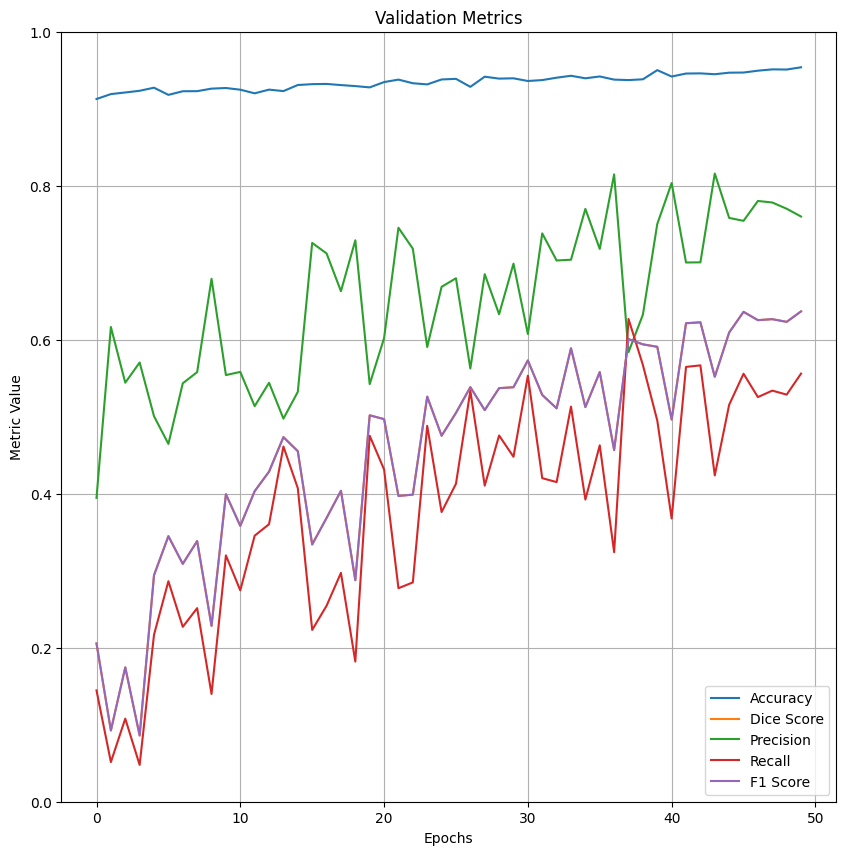

In [33]:


def read_metrics(filename):
    with open(filename, "r") as file:
        lines = file.readlines()

    metrics = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "accuracy": [],
        "dice_score": [],
        "precision": [],
        "recall": [],
        "f1_score": []
    }

    epoch = 0
    for line in lines:
        line = line.strip()
        if line.startswith("Train Loss:"):
            metrics["epoch"].append(epoch)
            metrics["train_loss"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Validation Loss:"):
            metrics["val_loss"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Accuracy:"):
            metrics["accuracy"].append(float(line.split(":")[1].strip())/100)
        elif line.startswith("Dice score:"):
            metrics["dice_score"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Precision:"):
            metrics["precision"].append(float(line.split(":")[1].strip()))
        elif line.startswith("Recall:"):
            metrics["recall"].append(float(line.split(":")[1].strip()))
        elif line.startswith("F1 Score:"):
            metrics["f1_score"].append(float(line.split(":")[1].strip()))
            epoch += 1

    return metrics

def plot_metrics(metrics, save_dir=None):
    epochs = metrics["epoch"]

    plt.figure(figsize=(10, 10))
    plt.plot(epochs, metrics["train_loss"], label="Train Loss")
    plt.plot(epochs, metrics["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    if save_dir:
        plt.savefig(os.path.join(save_dir, "loss_plot.png"))
    else:
        plt.show()

    plt.figure(figsize=(10, 10))
    plt.plot(epochs, metrics["accuracy"], label="Accuracy")
    plt.plot(epochs, metrics["dice_score"], label="Dice Score")
    plt.plot(epochs, metrics["precision"], label="Precision")
    plt.plot(epochs, metrics["recall"], label="Recall")
    plt.plot(epochs, metrics["f1_score"], label="F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("Metric Value")
    plt.title("Validation Metrics")
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    if save_dir:
        plt.savefig(os.path.join(save_dir, "metrics_plot.png"))
    else:
        plt.show()

metrics = read_metrics(model_dir + "/output/output.txt")
save_directory = model_dir + "/grafici"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)
plot_metrics(metrics, save_dir=save_directory)
